In [1]:
! pip install matplotlib numpy

# Ray Tracing

## Grundlagen

Was ist die grundlegende Idee von Raytracing?
Wichtig ist dafür zuerst zu verstehen wie Licht funktioniert.

Ein einfacher Ansatz dafür ist, anzunehmen das Licht aus Strahlen besteht.  
Diese Strahlen werden aus einer Lichtquelle ausgesendet, werden von Objekten reflektiert und absorbiert und zu guter Letzt kommen sie bei dem Beobachter an.  
Der Beobachter wird hier Kamera genannt.

Schematisch und zweidimensional sieht das so aus:
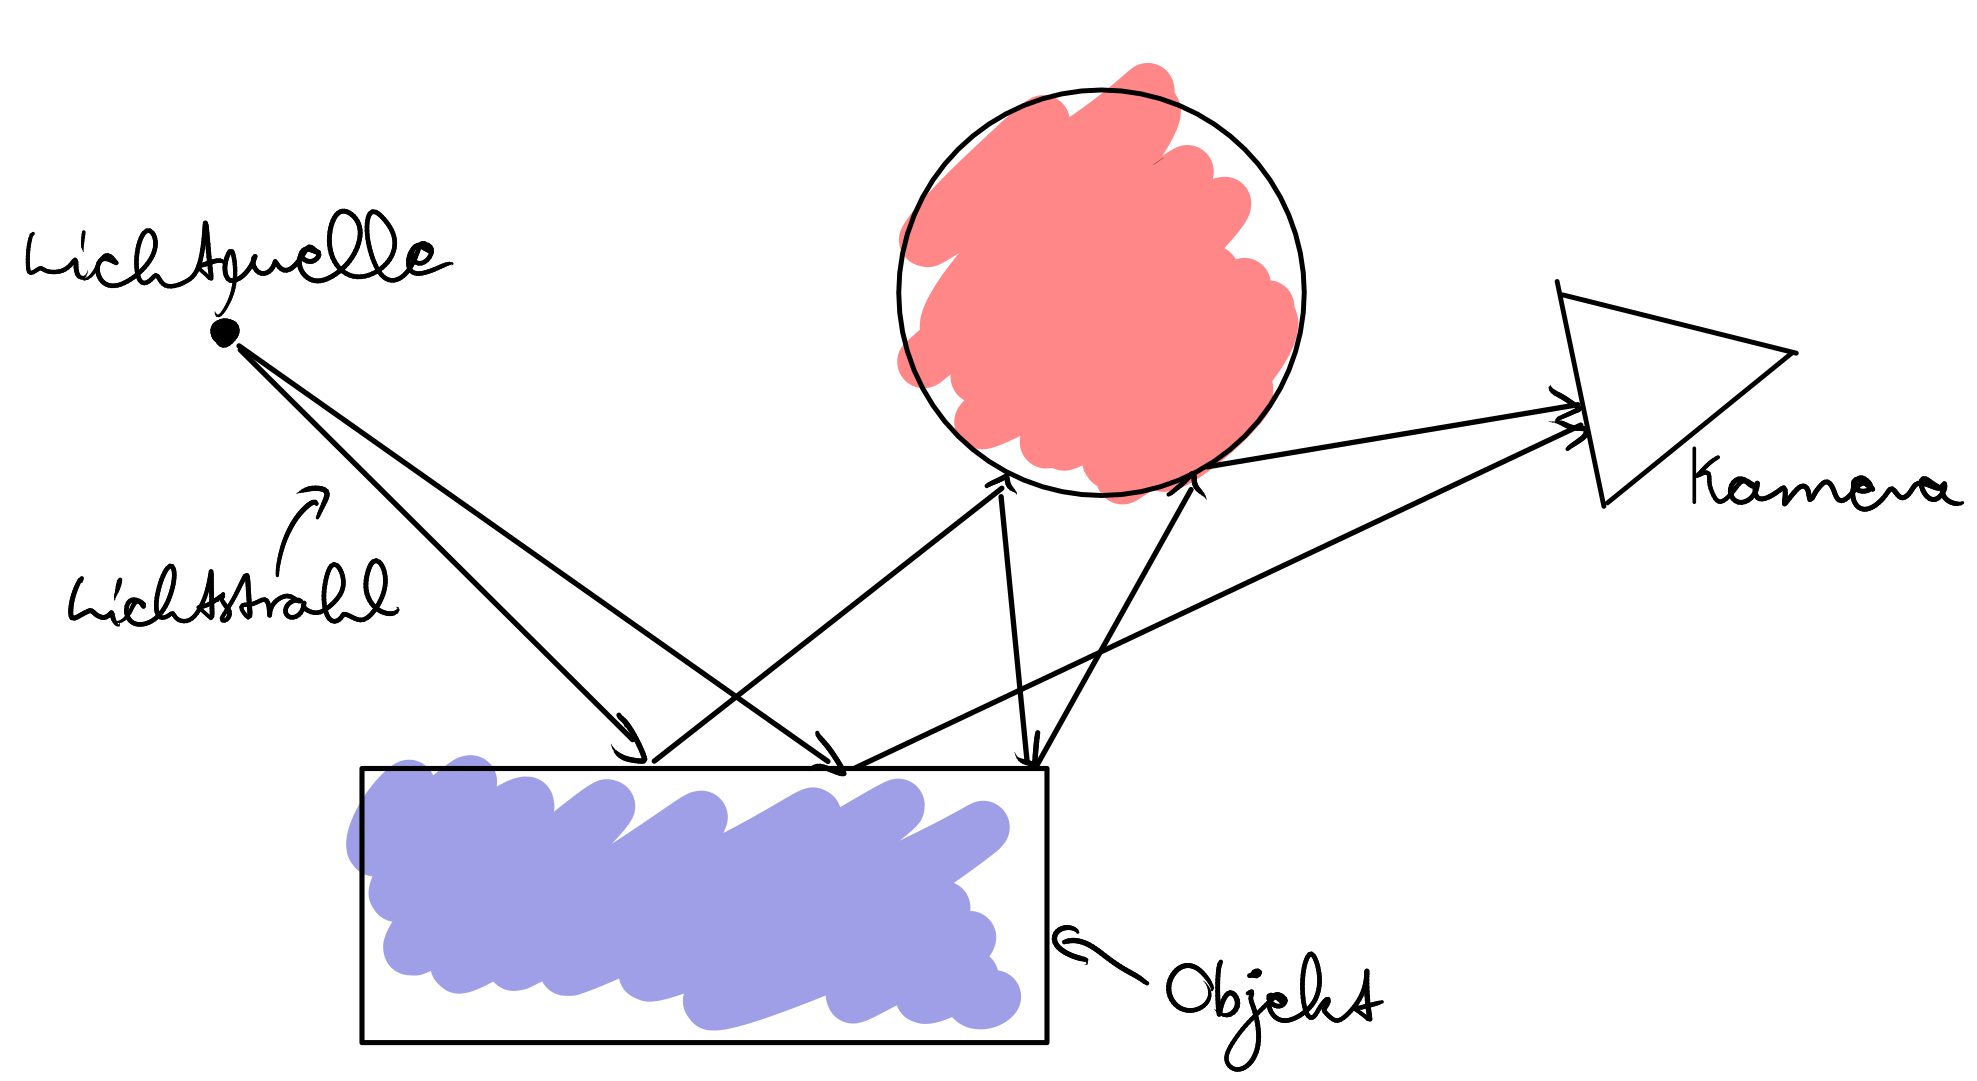

Schritt für Schritt müssen also folgende Dinge geschehen:

1. Die Lichtquelle sendet einen Lichtstrahl aus
2. Dieser Lichtstrahl trifft auf ein Objekt
3. Das Objekt reflektiert und absorbiert einen Teil des Lichts
4. Schritt 2 und 3 wiederholen sich bis der Lichtstrahl entweder eine Kamera oder kein Objekt mehr trifft
5. Lichtstrahl trifft auf die Kamera
6. Schritt 1 bis 6 werden wiederholt bis der Nutzer mit dem gerenderten Bild zufrieden ist

Dieser Ansatz ist allerdings sehr ineffizient, da dann viele Lichtstrahlen keine Kamera treffen.
Für eine bessere Optimierung werden die Lichtstrahlen aus der Kamera ausgesendet und der Lichtpfad wird erst nach dem Auftreffen auf die Lichtquelle vollständig berechnet.


## Lichtstrahlen (Rays)
    
Ein Lichtstrahl besteht aus Ortsvektor und Richtungsvektor.
Der Ortsvektor gibt dabei den Punkt an, an dem der Lichtstrahl ausgesendet wurde
und der Richtungsvektor die Richtung in die der Strahl gesendet wird.  
Also $\vec{ray(t)}=\vec{O}+\vec{d}*t$
außerdem hat ein Lichtstrahl eine Farbe `color`, die ist zu Beginn `[1,1,1]`

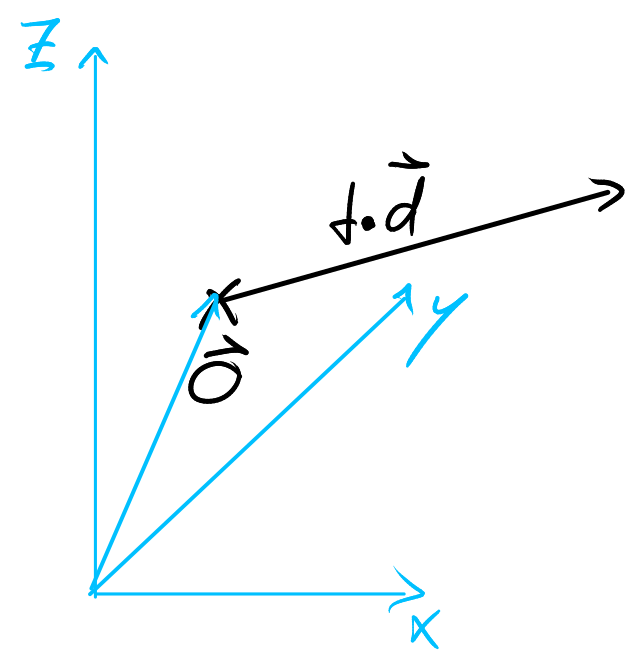

in Python definieren wir einen Ray so:

In [2]:
import numpy as np
import numpy.typing as npt
from typing import NamedTuple, Tuple

Vec = npt.NDArray[np.float64]
Color = npt.NDArray[np.float64]


class Ray(NamedTuple):
    location: Vec
    direction: Vec
    color: Color

    def at(self, t):
        return self.location + t * self.direction


Typischerweise ist der Richtungsvektor normiert, dafür dient diese Funktion


In [3]:
def normalizeVector(vec: Vec):
    return vec/np.linalg.norm(vec)


print(normalizeVector(np.array([1, 2, 3])))


[0.26726124 0.53452248 0.80178373]


## Aussenden eines Lichtstrahls

Die Kamera sendet Lichtstrahlen aus.
Die Kamera ist modelliert als eine Lochkamera. Es gibt einen Sensor, auf dem alle Pixel liegen. 
Der Sensor ist eine Fläche.
Alle Lichtstrahlen gehen von einem Punkt aus, der *Lochblende*.
Jeder Lichtstrahl geht in Richtung eines Pixels, sodass am Ende jedes Pixel einem Lichtstrahl zugeordnet werden kann.

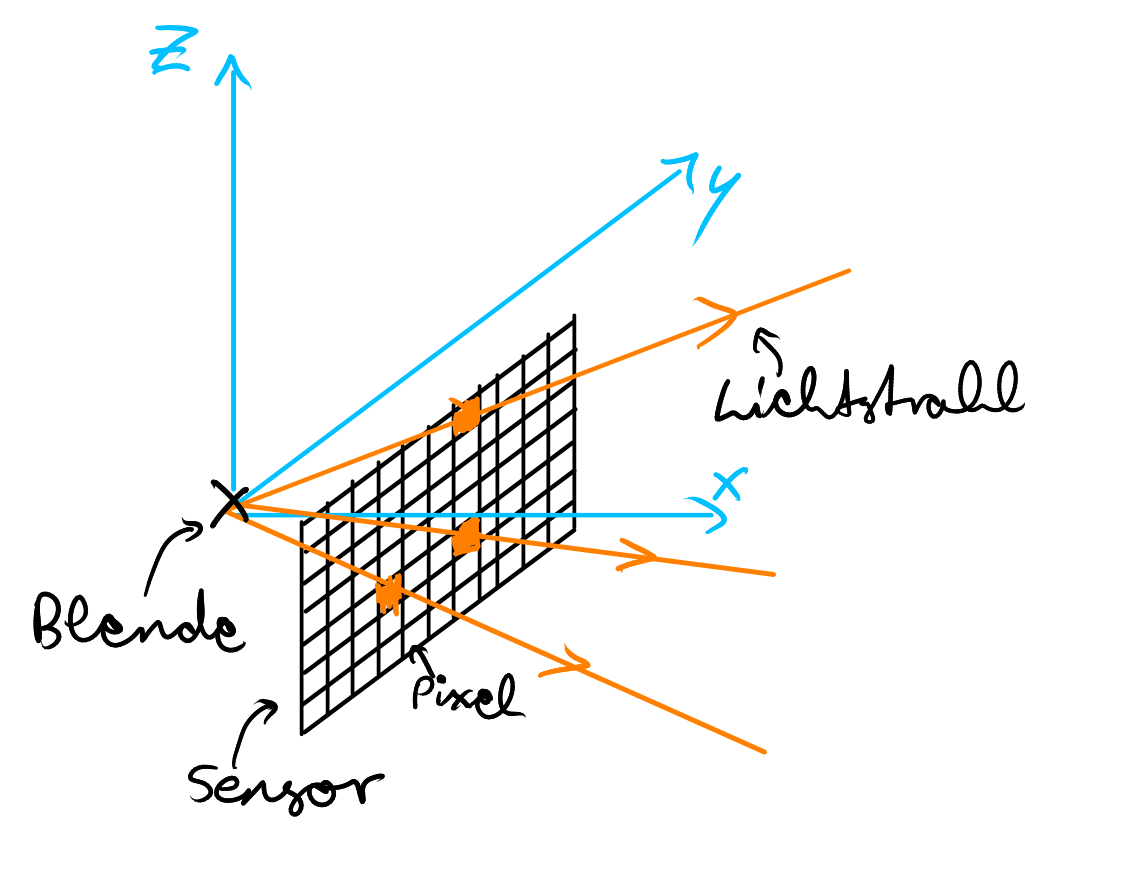

Damit können allerdings starke Treppenartefakte entstehen.
Um diese zu vermeiden werden die Lichtstrahlen nicht genau durch die Mitte jedes Pixels gesendet sondern durch einen zufälligen Punkt im Pixel.
<!--TODO erklärung Treppenartefakte-->

In [4]:
class ImageSize(NamedTuple):
    width: int
    height: int


class Camera:
    def __init__(
        self, imageSize: ImageSize,
        # set sane defaults
        position: Vec = np.array([0, 0, 0]), direction: Vec = np.array([1, 0, 0]), up: Vec = np.array([0, 0, 1])
    ) -> None:
        assert 0 < imageSize.width and 0 < imageSize.height, f"image cant have negative Dimestions, was {imageSize}"
        # setup
        self.imageSize = imageSize
        # sensor plane is 1 unit diagonal calculate the size of a pixel within 1 unit diagonal sensor
        self.unitPerPixel = np.sqrt(
            self.imageSize.width ** 2 + self.imageSize.height ** 2)

        # set sensor and aperture position (sensor is in front of aperture with direction)
        self.sensorPosition = position+direction
        self.aperturePosition = position

        # set the up and left values of the sensor (where the top and the left side of the sensor is)
        self.up = normalizeVector(up)
        self.left = normalizeVector(np.cross(direction, self.up))

    def _getRay(self, pixelX: int, pixelY: int) -> Ray:
        assert 0 <= pixelX < self.imageSize.width, f"pixelX has to be in Image, was {pixelX}"
        assert 0 <= pixelY < self.imageSize.height, f"pixelY has to be in Image, was {pixelY}"

        # set pixel position from 2d to 3d and add random offset within pixel (for anti aliasing)
        x = -self.imageSize.width/2 + pixelX + np.random.rand()
        y = -self.imageSize.height/2 + pixelY + np.random.rand()

        # set the Pixel Position in 3D Space using the left and the up vectors
        pixelPos = self.sensorPosition - self.left * \
            (x/self.unitPerPixel) - self.up*(y/self.unitPerPixel)

        # calculate ray direction
        rayDirection = normalizeVector(pixelPos - self.aperturePosition)

        # return Ray
        return Ray(self.aperturePosition, rayDirection, np.array([1, 1, 1]))


camera = Camera(ImageSize(8, 8),  np.array(
    [1, 0, 0]), np.array([1, 0, 0]),  np.array([0, 0, 1]))
camera._getRay(0, 0)


Ray(location=array([1, 0, 0]), direction=array([ 0.91801016, -0.30101829,  0.25815757]), color=array([1, 1, 1]))

## Schnittpunkt eines Lichtstrahls mit einem Objekt

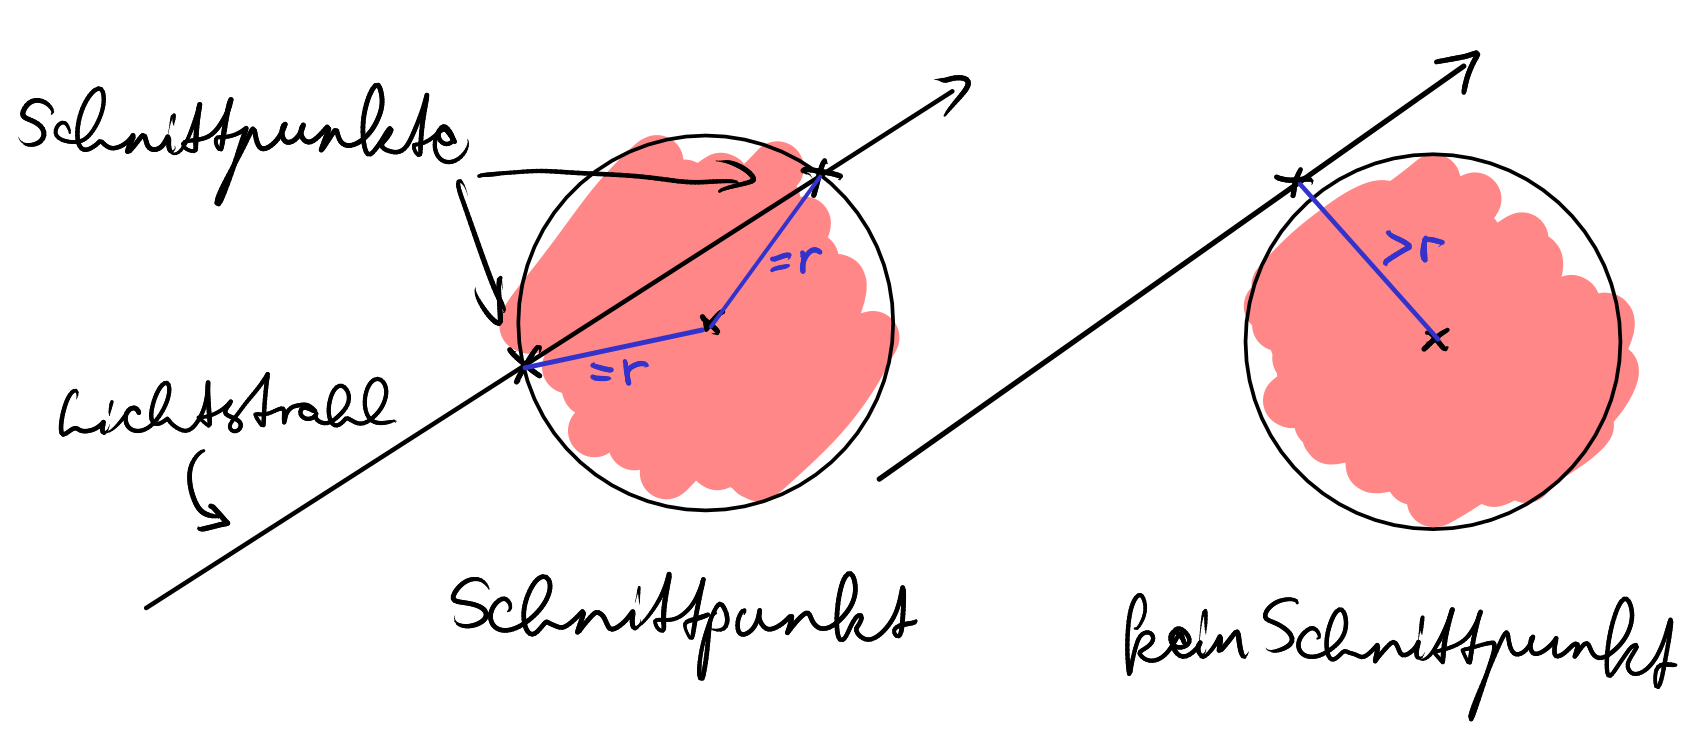

Nachdem der Lichtstrahl ausgesendet wurde, muss der erste Auftreffpunkt des Lichtstrahls auf einem Objekt berechnet werden.
Hier werden zur Vereinfachung nur Kreise als Objekte genutzt.
Schnittpunkte sind dabei alle Punkte, die genau den Radius $r$ des Kreises von dessen Mittelpunkt $C$ entfernt sind.
also:

$$
|\vec{P}-\vec{C}|=r
$$

Für die Lichtstrahlen gilt damit

$$
|\vec{ray(t)}-\vec{C}|=r
\\
|\vec{O}+\vec{d}*t-\vec{C}| = r
$$

umgeformt ergibt das eine Quadratische Gleichung:

$$
|\vec{d}|^2*t^2+2t*<\vec{d},\vec{O}-\vec{C}>+<\vec{O}-\vec{C},\vec{O}-\vec{C}>-r^2=0
$$

um die Schnittpunkte heruaszufinden, muss die Gleichung nacht $t$ aufgelöst werden.
Damit ergibt sich für $t$:

$$
a = |\vec{d}|^2
\\
b = 2*<\vec{d},\vec{O}-\vec{C}>
\\
c = <\vec{O}-\vec{C},\vec{O}-\vec{C}>-r^2
\\
t_{1,2}=\frac{-b\pm \sqrt{b^2-4*a*c}}{2*a}
$$

Damit gibt es nur Schnittpunkte für $b^2-4*a*c\geq 0$.  
In einer Szene kann es allerdings mehrere Objekte geben, die Schnittpunkte mit dem Lichtstrahl haben.
Der Auftreffpunkt des Lichtstrahls ist der erste Schnittpunkt der Geraden.
Das bedeutet der Auftreffpunkt ist der Punkt für den $t$ minimal aber größer $0$ ist.


In [5]:
from abc import ABC, abstractmethod


class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray):
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float) -> None:
        self.center = center
        self.radius = radius
        super().__init__()

    def hit(self, ray: Ray):
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta >= 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = min(t1, t2)
            t = t if t > 0 else max(t1, t2)
            t = None if t < 0 else t
            return t
        return None


ray = Ray(np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([1, 1, 1]))
circle: Object = Circle(np.array([5, 0, 0]), 1)
circle.hit(ray)


4.0

## Erster Test

Nun kann alles ein erstes Mal getestet werden.
Dafür wird eine einfache Render Funktion erstellt.
Diese kann unterscheiden, ob ein Objekt mit einem Lichtstrahl getroffen wurde oder nicht.
Der Ablauf hier ist wie folgt:

1. Es wird ein Lichtstrahl für ein Pixel generiert
2. Es wird berechnet ob der Lichtstrahl ein Objekt trifft
3. Wenn der Lichtstrahl ein Objekt trifft bekommt der Pixel den Wert 1, sonst 0

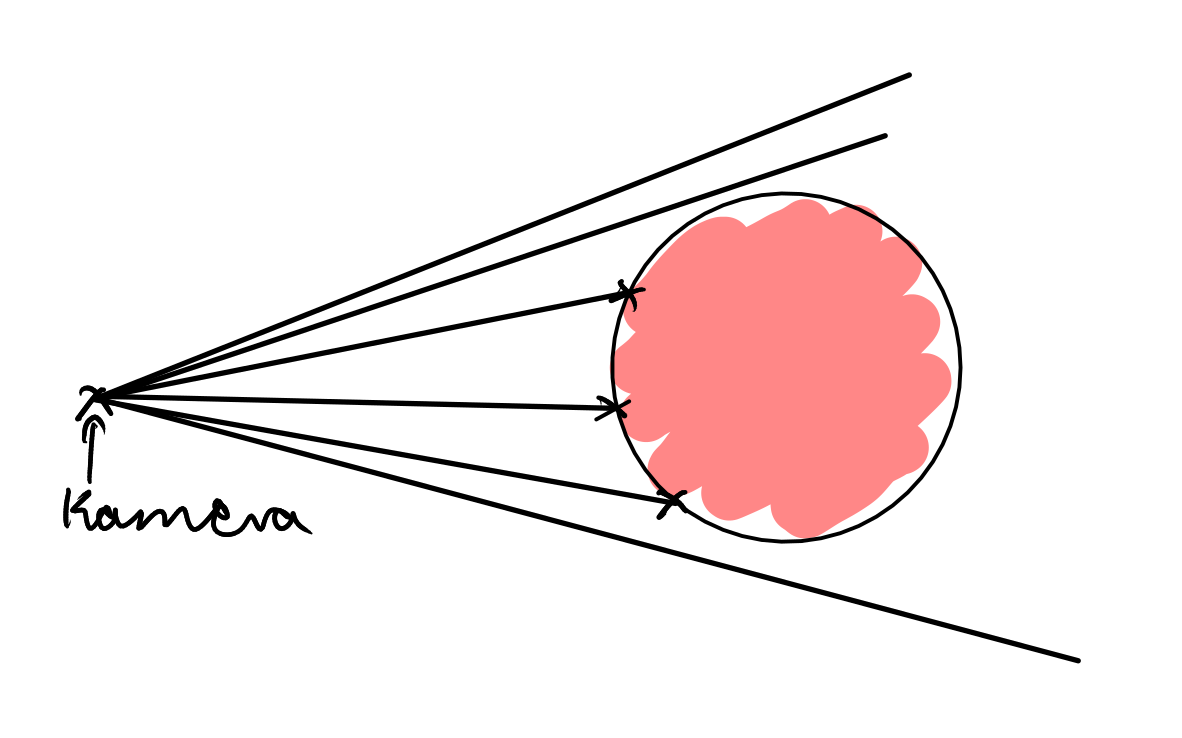


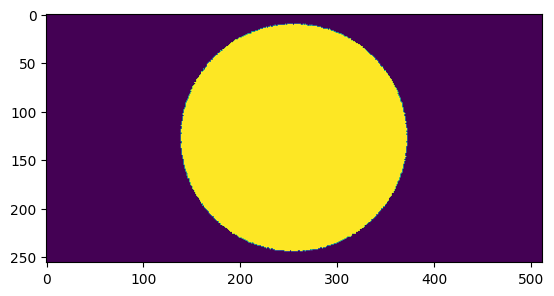

In [6]:
import matplotlib.pyplot as plt

camera = Camera(ImageSize(256, 512))
objects = [Circle(np.array([5, 0, 0]), 1)]


def render(camera: Camera, objects):
    img = np.zeros(camera.imageSize)
    for x in range(camera.imageSize.width):
        for y in range(camera.imageSize.height):
            ray = camera._getRay(x, y)
            hits = []
            for obj in objects:
                hit = obj.hit(ray)
                if hit is not None:
                    hits.append(hit)
            if len(hits) > 0:
                img[x, y] = 1
    return img


plt.imshow(render(camera, objects))


## Materialien

Bis jetzt gibt es nur zwei Zustände: Der Lichtstrahl trifft ein Objekt und der Lichtstrahl trifft kein Objekt.
Das reicht allerdings nicht aus, um ein Bild zu erzeugen. Dafür werden nun Materialien eingeführt, die den Objekten eine Farbe geben.  
Jedem Objekt wird nun ein Material zugeordnet.  
Später sollen die Materialien physikalische Eigenschaften das Materials, aus dem ein Objekt besteht, wiederspiegeln.  
Ein Material soll also in Zukunft aussagen welche Farbe ein Objekt hat,
wie stark Licht reflektiert wird,
ob ein Objekt diffus ist oder spiegelt oder ob es durchsichtig ist.  
Um die Funktionalität der Materialien erst einmal zu testen,
deffinieren die Materialen zuerst nur die Farbe des Objektes.

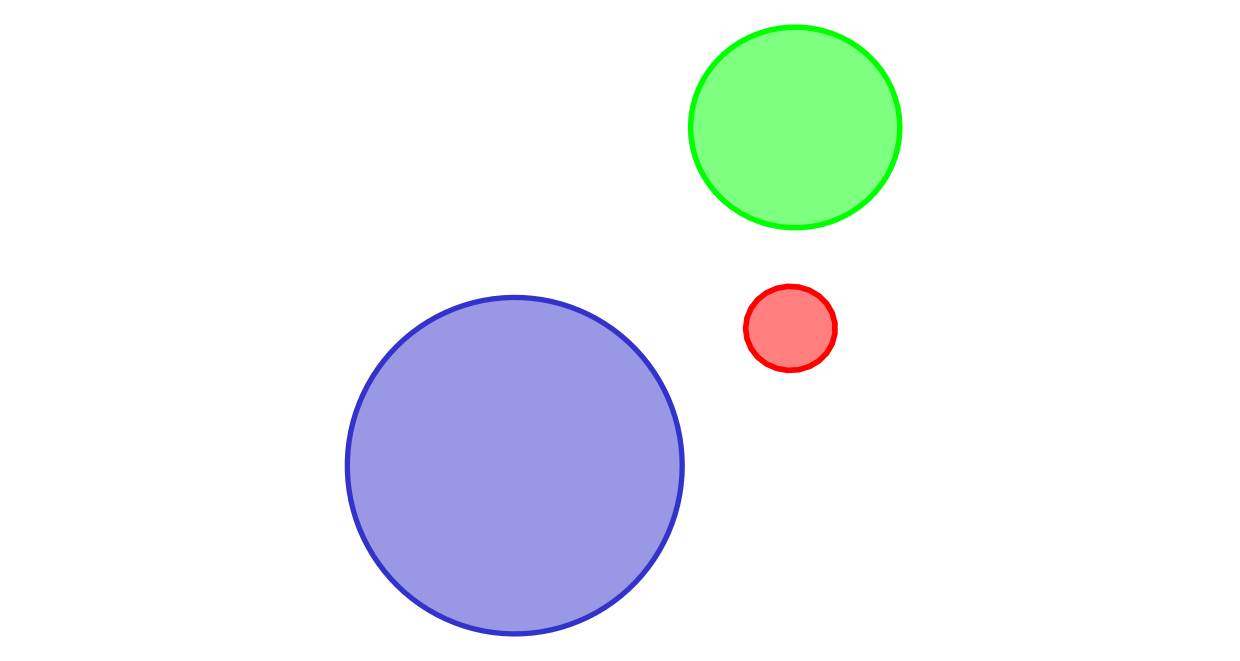


In [7]:
# NEU: es gibt ein Material, in dem eine Farbe deffiniert ist
class Material():
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

# NEU: wenn ein Objekt getroffen wird, muss zusätzlich das Material des Objekts zurück gegeben werden


class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray):
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def hit(self, ray: Ray):
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = min(t1, t2)
            t = t if t > 0 else max(t1, t2)
            return None if t < 0 else (t, self.material)
        return None


Mit der Einführung von Materialien muss auch die Rendering Funktion angepasst werden.
Ein Lichtstrahl nimmt nun die Farbe des Objekts an, das er getroffen hat
und jedes Pixel bekommt die Farbe seines zugehörigen Lichtstrahls.

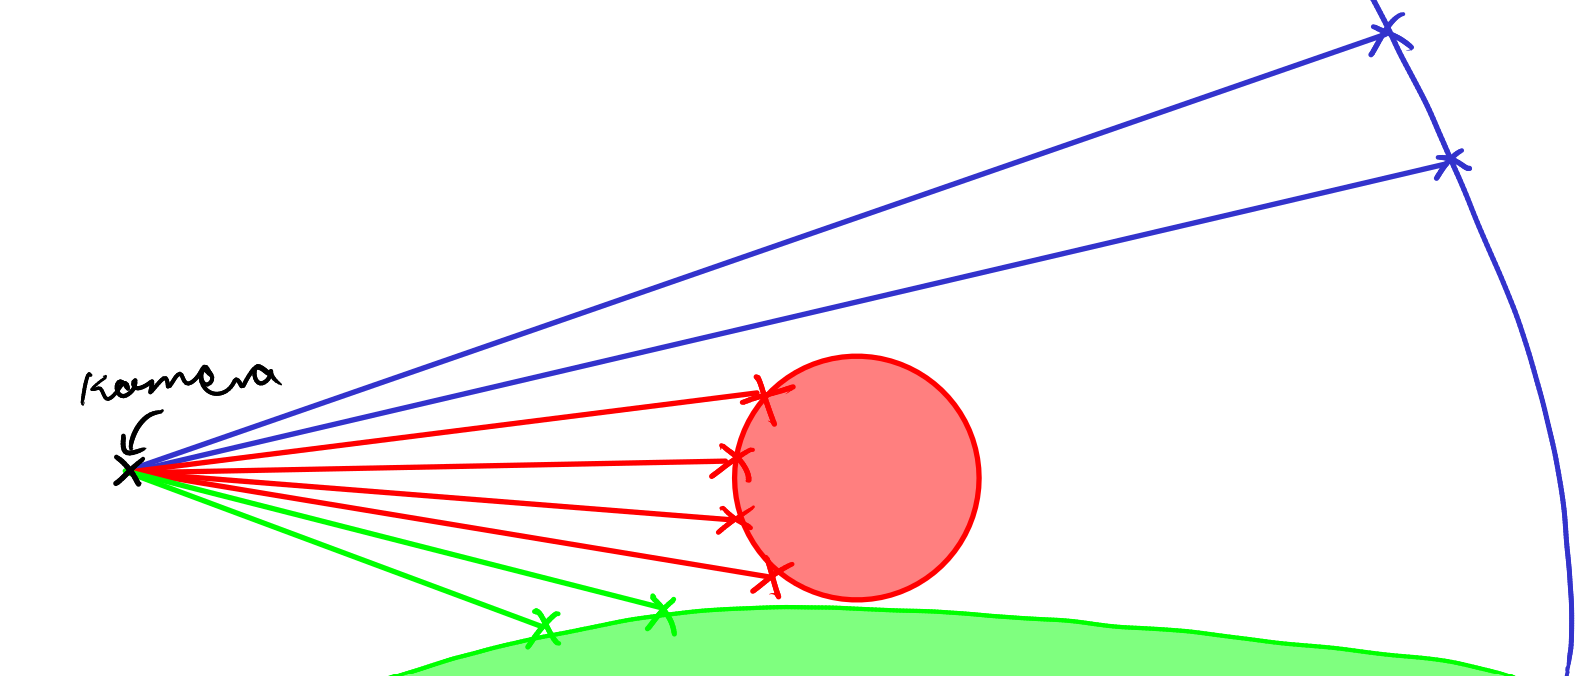


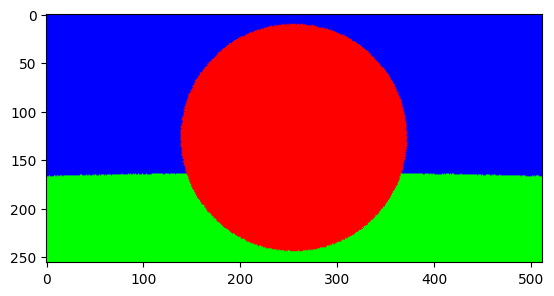

In [8]:
camera = Camera(ImageSize(256, 512))
objects = [Circle(np.array([50, 0, 0]), 10, Material([1, 0, 0])),
           Circle(np.array([0, 5000, 0]), 4990, Material([0, 1, 0])),
           Circle(np.array([0, 0, 0]), 5000, Material([0, 0, 1]))]


def render(camera: Camera, objects):
    img = np.zeros((camera.imageSize.width, camera.imageSize.height, 3))
    for x in range(camera.imageSize.width):
        for y in range(camera.imageSize.height):
            ray = camera._getRay(x, y)
            hits: list[Tuple[float, Material]] = []
            for obj in objects:
                hit = obj.hit(ray)
                if hit is not None:
                    hits.append(hit)
            if len(hits) == 0:
                img[x, y] = [0, 0, 0]
                continue
            criticalHit = min(hits, key=lambda hit: hit[0])
            img[x, y] = criticalHit[1].color * ray.color
    return img


plt.imshow(render(camera, objects))


## Reflexion/Absorption

Während in dem vorherigen Modell die Lichtstrahlen mit dem Auftreffen auf ein Objekt beendet werden,
reflektieren Objekte in der realen Welt die Lichtstrahlen in aller Regel weiter.
Das soll in diesem Raytracing Modell auch dargestellt werden.

Die Reflektion, Absorption und Brechung des Lichts kann algorithmisch verschieden umgesetzt werden.
Eines haben die meisten dieser Algorithmen allerdings gemeinsam:
Es muss bekannt sein in welcher Orientierung sich das Objekt befindet. Das wird mit dem Normalenvektor umgesetzt.
Also muss nun beim Auftreffen eines Lichtstrahls auf einem Objekt zusätzlich der Normalenvektor zurückgegeben werden.

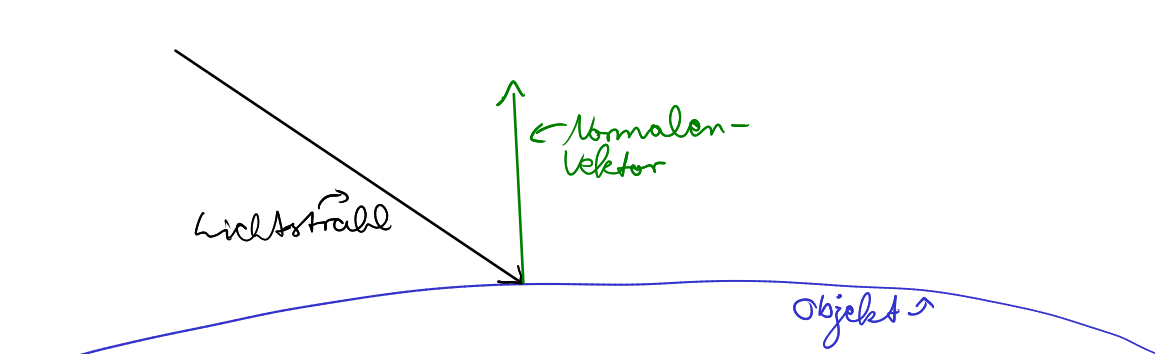


In [9]:
# NEU: neben dem Material, muss nun auch der Normalenvektor des Objekts
# beim Auftreffen der Lichtstrahlen zurückgegeben werden.
# Um den Rückgabewert lesbarer zu machen, wird ein Rückgabeobjekt eingeführt

# NEU
class ObjHit(NamedTuple):
    t: float
    material: Material
    normal: Vec


class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray):
        # --------------------------- Neu ^
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def hit(self, ray: Ray):
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = min(t1, t2)
            t = t if t > 0 else max(t1, t2)
            normal = normalizeVector(ray.at(t) - self.center)
            # Neu ^
            return None if t <= 0 else ObjHit(t, self.material, normal)
        return None


Ein einfaches Material-Modell, ist das Lambertsche Modell.
Mit diesem lassen sich diffuse Matterialien wie Papier oder Ton
aber auch metallische und andere Spiegelnde Materialien darstellen.
Bei diffusen Materialien sagt das Lambertsche Reflektionsmodell aus,
dass Licht in alle Richtungen gleich reflektiert wird,
aber bei hohem Auftreffwinkel mehr reflektiert wird als bei niedrigem Auftreffwinkel.
Die Intensität der Reflektion ist dabei proportional
zum Cosinus zwischen Normalenverktor und Lichtstrahl.

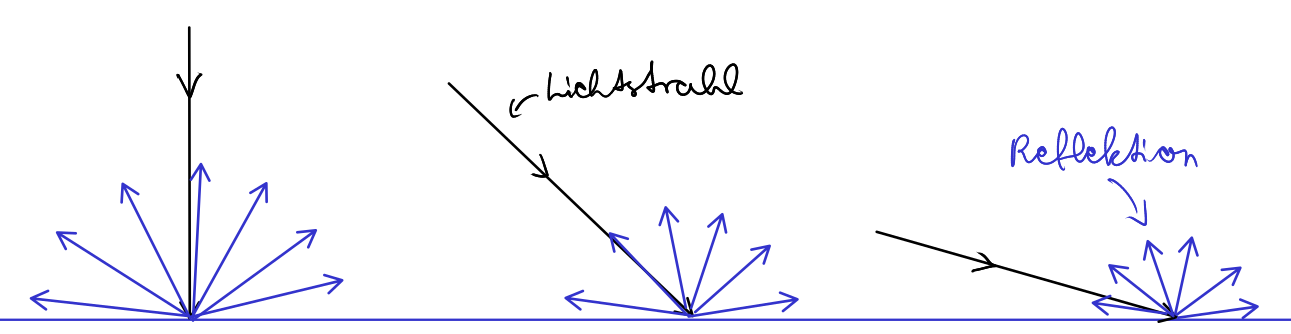


Grundsätzlich entstehen beim Reflektieren eines Lichtstrahls, wie in dieser Grafik dargestellt,
unendlich viele neue Lichtstrahlen, die in alle Richtungen reflektiert werden.
In einem Computer können in endlicher Zeit allerdings nicht unendlich viele Lichtstrahlen berechnet werden,
daher ist eine Aprroximation nötig.  
Anstatt bei der Reflektion unendlich viele Lichtstrahlen auszusenden wird nur ein Lichtstrahl entsprechend dem Lambertschen Reflektionsmodell ausgesendet.
Wenn dann die Anzahl der Lichtstrahlen, die die Kamera aussendet gegen unendlich geht
und damit auch die Anzahl der Lichtstrahlen die auf einen Punkt auftreffen gegen unendlich geht,
wird das Modell genauer und damit das resultierende Bild besser.
Es muss außerdem beachtet werden, dass in diesem Raytracer die Lichtstrahlen von der Kamera ausgehen und beim Auftreffen auf eine Lichtquelle rückverfolgt werden.
Daher muss das Reflektionsmodell quasi invertiert werden.

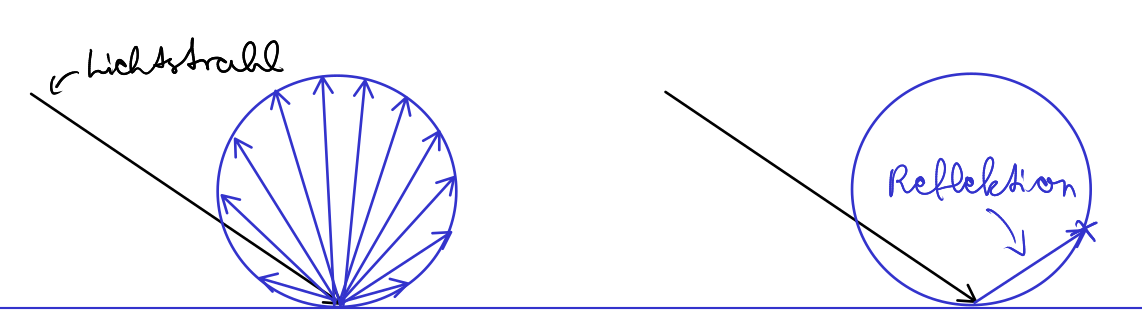

Links ist das Lambertsche Reflektionsmodell mit von der Kamera ausgehenden Lichtstrahlen dargestellt
und rechts ist die Approximation mit nur einem Lichtstrahl gezeigt.
Es ist also nötig einen zufälligen Punkt auf der Kugeloberfläche zu wählen. Das wird mit der folgenden Funktion implementiert.


In [10]:
def randomOnUnitSphere() -> Vec:
    randNumber = np.random.randn(3)
    return randNumber / np.linalg.norm(randNumber)


randomOnUnitSphere()


array([ 0.47121616,  0.17737138, -0.86399926])

Neben einem Diffusen anteil, haben viele Materialien auch einen spiegelnden Anteil.
Das Lambertsche Modell gibt die Intensität des reflektierten Lichts abhängig von einfallswinkel $i$ und ausfallswinkel $o$ wiefolgt an:
$$\Phi(i,o)=a\cos(i)+b\cos^m(o)+c$$
Dabei ist $a$ die Menge an diffus reflektiertem Licht,
$b$ die Menge an gespiegelt reflektiertem Licht,
$m$ der Spiegelungsindex des Materials
und $c$ die Menge Licht, die das Objekt selbst ausstrahlt.  
$c$ wird hier allerdings nicht beachtet und in einem eigenen emmisiven Material implementiert.

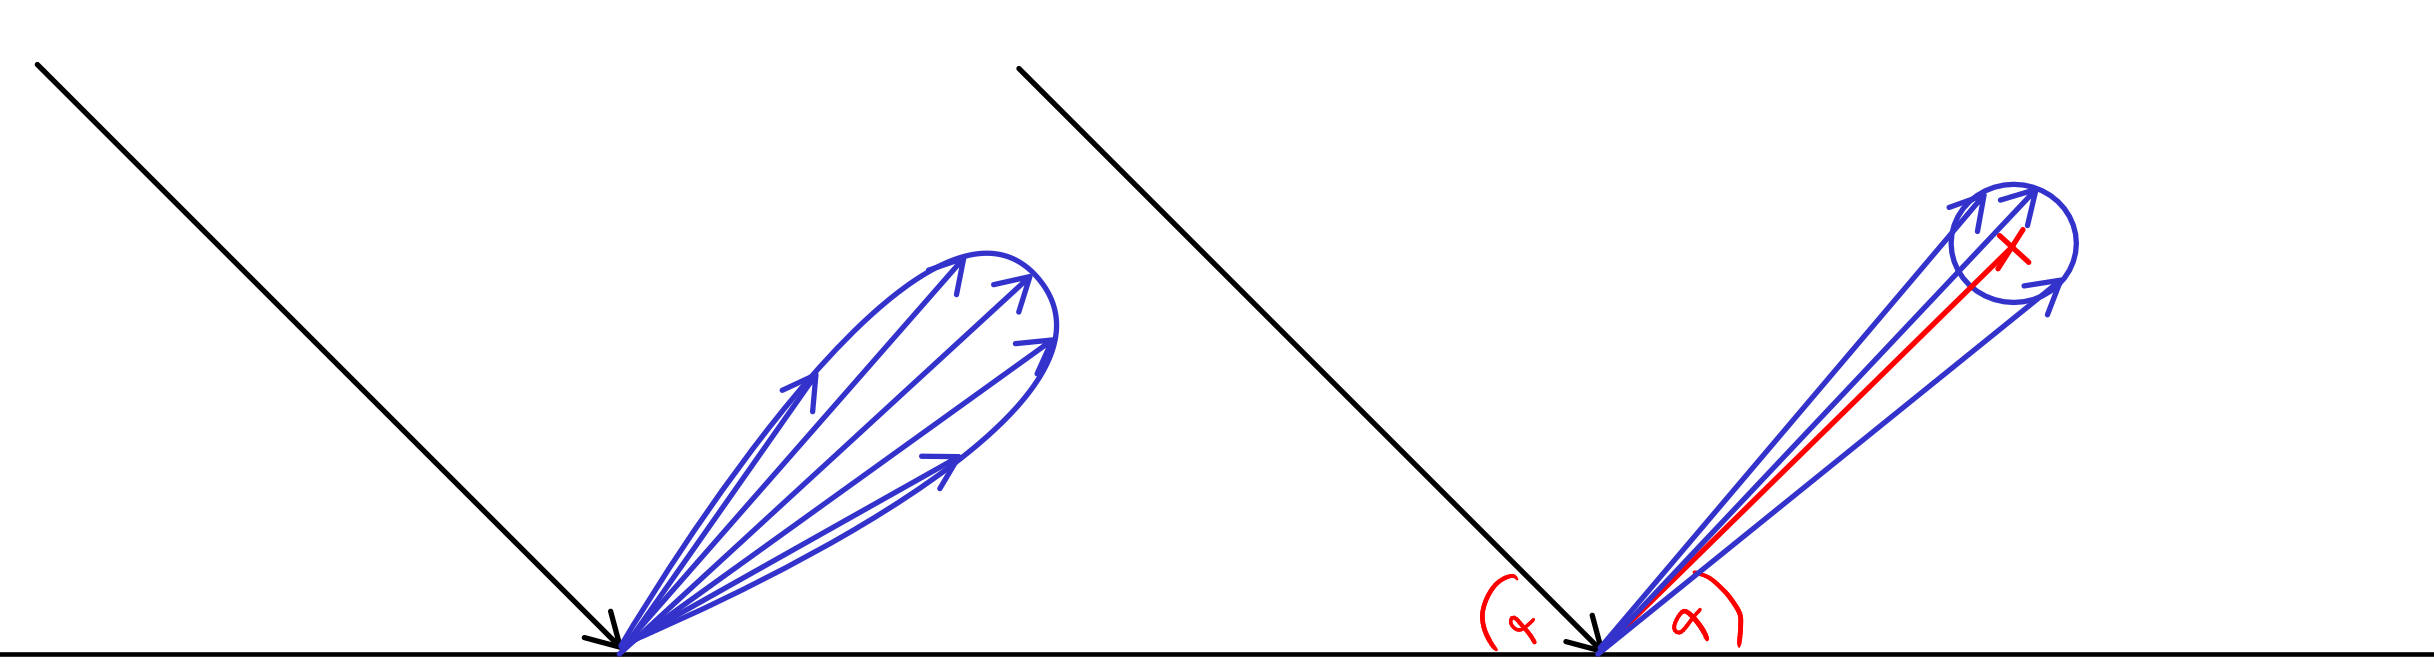

Der Spiegelnde Anteil ist in der Grafik links dargestellt. Da mit $\cos^m(o)$ recht schwer zu rechnen ist,
wird eine Approximation gewählt.
Dabei wird eine Ideale Reflektion gebilted und von dort aus
ein Offset zu einer Kugel hinzugezählt.
Der Radius der Kugel hängt dann mit dem Spiegelungsindex des Materials zusammen.

nun wird mit der Warschenlichkeit $\frac{a}{a+b}$ der diffuse Anteil des Matterials
und mit der Warscheinlichkeit $\frac{b}{a+b}$ der spiegelnde Anteril des Matterials gewählt.


In [11]:
def reflect(inputVector: Vec, normal: Vec) -> Vec:
    return inputVector - 2 * np.dot(inputVector, normal) * normal


reflect(np.array([-1, -2, -3]), np.array([1, 0, 0]))


array([ 1, -2, -3])

Mit diesem Wissen kann ein neues Material implementiert werden.
Da es mehrere verschiedene Materialien geben wird,
wird ein Material als abstrakte Klasse implementiert.
Diese hat eine Funktion, die mit dem eingehenden Lichtstrahl, dem Normalenvektor und dem Auftreffpunkt, den ausgehenden Lichtstrahl berechnet.

Da die Szene allerdings vollkommen dunkel wäre, wenn es nur Lambertsche Materialien gibt, muss es auch noch eine Lichtquelle geben.
Dieses wird auch als Material, einem emissiven Material, implementiert.
Ein emmisives Material reflektiert keine Lichtstrahlen und muss beim Rendern das Rendering beenden.
Der Pfad eines Lichtstrahls in diesem Raytracer beginnt in der Kamera endet bei einer Lichtquelle.


In [12]:
# NEU: ein Material deffiniert eine Methode die mit dem eigehenden Lichtstrahl
# aus dem eingehenden Lichtstrahl berechnet
# Das Material ist außerdem abstrakt
class Material(ABC):
    @abstractmethod
    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        pass


# NEU: das Lambertsche Material
class Lambert(Material):
    def __init__(self, diffuseColor,  specularColor=np.array([0, 0, 0]), diffuseVsSpecular=1, specularIndex=0) -> None:
        self.diffuseColor = diffuseColor
        self.specularColor = specularColor
        self.diffuseVsSpecular = diffuseVsSpecular
        self.specularIndex = specularIndex
        super().__init__()

    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        # Auswahl diffus oder specular (zahl zwischen [0,1])
        select = np.random.rand(1)

        # Ray werte inizialisieren
        location = hitPoint
        color = np.zeros((3))
        direction = np.zeros((3))

        # Werte die sonnst genutzt werden inizialisieren/normieren
        randomOnSphere = randomOnUnitSphere()
        normal = normalizeVector(normal)

        # Reflektionsanteil berechnen
        if (select > self.diffuseVsSpecular):
            reflected = reflect(normalizeVector(inRay.direction), normal)
            direction = reflected + self.specularIndex * randomOnSphere
            color = inRay.color * self.specularColor
            if (np.dot(direction, normal) < 0):
                direction = reflected

        # diffusen anteil berechnen
        if (select <= self.diffuseVsSpecular):
            point = randomOnSphere + normal + hitPoint
            direction = point - hitPoint
            color = inRay.color * self.diffuseColor

        # Werte normieren
        direction = normalizeVector(direction)

        # neuen Ray zurückgeben
        return Ray(location, direction, color)

# NEU: das Emmisive Material


class Emissive(Material):
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        direction = np.array([0, 0, 0])
        location = np.array([0, 0, 0])
        color = inRay.color * self.color
        return Ray(location, direction, color)


Nun muss auch die Render-Funktion angepasst werden.
Nachdem ein Lichtstrahl von der Kamera ausgesendet wurde, wird der erste Auftreffpunkt des Lichtstrahls auf einem Objekt berechnet. Zuvor hatte der Lichtstrahl hier geendet.
Nun wird der Lichtstrahl von dem Objekt bestimmt reflektiert wodurch ein neuer Lichtstrahl entsteht.
Dieser kann dann auch wieder auf Objekte auftreffen und wieder reflektiert werden. Die Maximale Anzahl an Reflektionen ist durch die Variable `bounces` beschränkt.
Jeder Lichtstrahl ist einem Pixel zugeordnet und nachdem der Lichtstrahl nicht weiter reflektiert wird, (da entweder die maximale Anzahl Reflektionen erreicht ist, der Lichtstrahl in einer Lichtquelle angekommen ist oder der Lichtstrahl keine weiteren Objekte trifft) wird der Farbwert des Pixels um den Farbwert des Lichtstrahls erhöht.


In [13]:
camera = Camera(ImageSize(128, 256))
objects = [Circle(np.array([75, 0, 0]), 10, Lambert([0.5, 0.7, 0.5], 1)),
           Circle(np.array([75, 0, -20]), 10,
                  Lambert([0, 0, 0], [0.5, 0.7, 0.5], 0, 0)),
           Circle(np.array([75, 0, 20]), 10, Lambert(
               [0, 0, 0], [0.5, 0.7, 0.5], 0, 0.5)),
           Circle(np.array([0, 5000, 0]),
                  4990, Lambert([0.5, 0.5, 0.7])),
           Circle(np.array([0, 0, 0]), 5000, Emissive([5, 5, 5]))]


def render(camera: Camera, objects, bounces: int = 5, itterations: int = 1):
    img = np.zeros((camera.imageSize.width, camera.imageSize.height, 3))
    for j in range(itterations):
        for x in range(camera.imageSize.width):
            for y in range(camera.imageSize.height):
                ray = camera._getRay(x, y)
                for i in range(bounces):
                    hits = []
                    for obj in objects:
                        hit = obj.hit(ray)
                        if hit is not None:
                            hits.append(hit)
                    if len(hits) == 0:
                        img[x, y] = [0, 0, 0]
                        break
                    criticalHit = min(hits, key=lambda hit: hit[0])
                    point = ray.at(criticalHit.t)
                    ray = criticalHit.material.outRay(
                        ray, criticalHit.normal, point)
                    if all(ray.direction == 0):
                        break
                img[x, y] += ray.color
    return img


img = render(camera, objects, 5, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


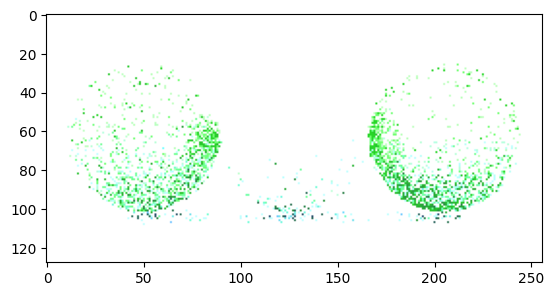

In [14]:
plt.imshow(img)


Das bild ist jetzt allerdings noch viel zu hell um sinnvoll angezeigt zu werden.
Hier verhält sich das Licht wie in der realen Welt, es ist unbegrenzt und linear.
Im Computer kann Licht aber nicht so dargestellt werden.
Zuerst müssen die Pixelwerte auf Werte zwischen 0 und 1 begrenzt werden.
Dabei deffiniert der hellste Pixel im Bild den Maximalwert von 1.
Nun sind alle Werte auf Werte zwischen 0 und 1 begrenzt aber weriterhin linear.
Um das Bild richtig darzustellen ist noch eine Gamma Korrektur nötig.
Dafür wird die folgende Formel verwendet: $x_{\gamma}=x^{\gamma}$.
Die Gamma Korektur nutzt aus, dass das menschliche Auge
auf Hellichkeitsänderungen in dunklen Bereichen stärker
als auf Hellichkeitsänderungen in hellen Bereichen reagiert.
Also benötigt ein Gamma codiertes Bild bei gleicher Hellichkeitsauflösung
eine geringere Bittiefe als ein linear codiertes Bild.
Die Gamma codierung sorgt so für eine Platzerspaarniss.
Computerbildschirme nutzen ein Gamma von $0.45$.
Um ein Lineares Bild auf einem solchen Bildschirm korrekt darzustellen,
muss das Bild auch mit einem Gamma von $0.45$ angezeigt werden.
Alle Korrekturen werden von der `correctAndShowImage` funktion durchgeführt
und das Bild wird nun korrekt angezeigt.


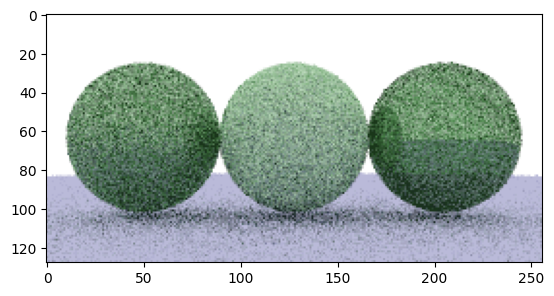

In [15]:
def correctAndShowImage(img):
    m = np.max(img)
    i = np.power((img/m), 0.45)
    plt.imshow(i)


correctAndShowImage(img)


## Dreiecke

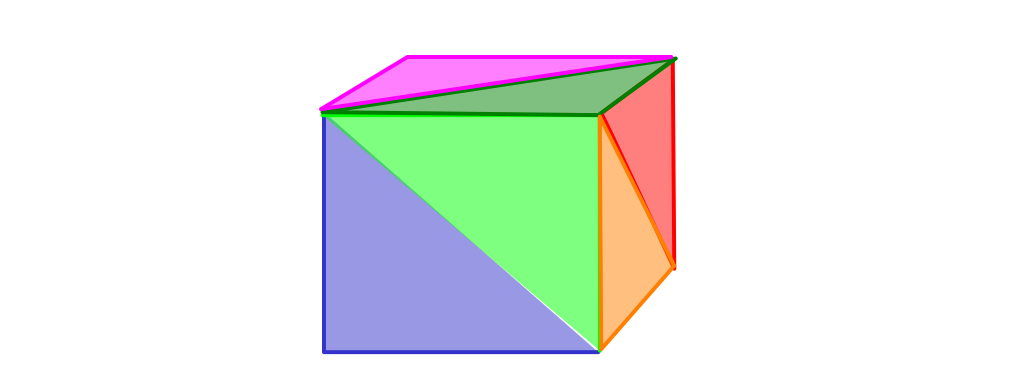

Bis jetzt kann der Raytracer nur Kugeln rendern.
Reale Objekte bestehen allerdings nicht nur aus Kugel.
Dafür werden nun Dreiecke eingeführt.
Mit genügend vielen Dreiecken kann jedes Objekt erstellt werden.
Hier ist beispielsweise ein Quader mit Dreiecken dargestellt.
Zur besseren Erkennbarkeit sind die einzelnen Dreiecke verschieden eingefärbt.
Modelle werden meist mit sehr vielen Dreiecken dargestellt.
Daher ist es eigentlich unnötig Kugeln darstellen zu können.
Hier wurden Kugeln trotzdem als erstes Beispiel genommen,
da sie algorithmisch einfacher umzusetzen sind.


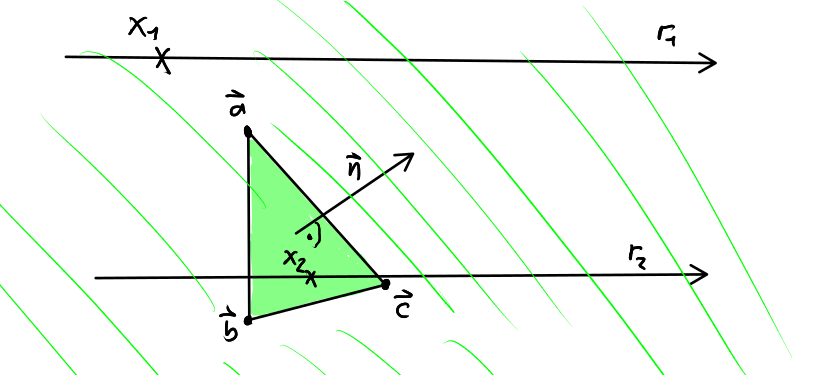

Ein Dreieck besteht aus 3 Punkten $\vec{a},\vec{b},\vec{c}$, die das Dreieck aufspannen.  
Um den Auftreffpunkt eines Lichtstrahls auf dem Dreieck zu berechnen, wird nun eine Ebene aus den drei Punkten gebildet.
Die Ebene soll in Normalenform vorliegen.
Dafür wird der Normalenvektor gebildet: $\vec{n} = (\vec{b}-\vec{a}) \times (\vec{c}-\vec{a})$.
Ein Punkt liegt dann auf der Ebene, wenn für $\vec{x}$ gilt: $<(\vec{x}-\vec{a}),\vec{n}> = 0$.
Um den Punkt zu finden, bei dem ein Lichtstrahl auf der Ebene liegt,
muss ein $t$ gefunden werden, sodass $<((\vec{ray(t)})-\vec{a}),\vec{n}> = 0$

$$
<(\vec{O}+\vec{d}*t)-\vec{a},\vec{n}>=0
\\
<\vec{O},\vec{n}> + t*<\vec{d},\vec{n}> - <\vec{a},\vec{n}> =0
\\
t = - \frac{<\vec{O},\vec{n}>-<\vec{a},\vec{n}>}{<\vec{d},\vec{n}>}
\\
t = \frac{<\vec{a}-\vec{O},\vec{n}>}{<\vec{d},\vec{n}>}
$$

Wenn $<\vec{d},\vec{n}> = 0$ dann ist der Lichtstrahl Parallel und die Ebene ist nicht getroffen.
Auch wenn die Ebene getroffen wurde, heißt das nicht, dass der Punkt auch in dem Dreieck ist.
Das mus zusätzlich getestet werden.
In der Grafik ist das auch erkenbar. Punkt $x_1$ ist zwar ein Schnittpunkt mit der Ebene, liegt aber nicht im Dreieck, Punkt $x_2$ dagegen schon.


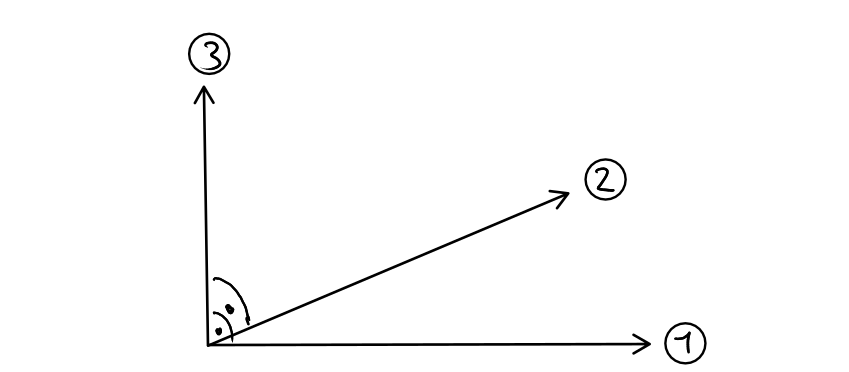

Um herauszufinden ob der Ebenenschnittpunkt im Dreieck liegt,
werden die Eigenschaften des Kreuzsproduktes ausgenutzt.
Wenn der zweite Vektor im Kreuzprodukt gegen den Uhrzeigersinn vom ersten Vektor liegt,
dann ist das Kreuzprodukt ein Vektor zum Bebobachtungspunkt.
Das ist in der Grafik oben dargestellt.
Wenn der zweite Vektor zum Ersten Vektor im Uhrzeigersinn steht,
dann zeigt das Kreuzprodukt (Vektor 3) weg vom Beobachtungspunkt.

Bei dem Dreieck werden nun an allen Eckpunkten das Kreuzprodukt zwischen kante und Eckpunkt zu Ebenenschnittpunkt aufgestellt.
Wenn der Ebenenschnittpunkt im Dreieck liegt, zeigen alle Kreuzprodukte in Richtung des Normalenvektors.
Das Skalarprodukt von Kreuzprodukt und Normalenvektor muss also größer $0$ sein.  
Notation: $\vec{ab}$ ist der Vektor zwischen den Punkten $\vec{a}$ und $\vec{b}$ also $\vec{b} - \vec{a}$
Es gilt damit folgendes:

$$
<\vec{ab} \times \vec{ax},\vec{n}> \;> 0\\
<\vec{bc} \times \vec{bx},\vec{n}> \;> 0\\
<\vec{ca} \times \vec{cx},\vec{n}> \;> 0
$$

<!--https://www.youtube.com/watch?v=XgUhgSlQvic -->
<!--TODO hier muss erklärt werden wie das mit den Normalenvektoren funktioniert-->


In [16]:
class Triangle(Object):
    def __init__(self, abc, material: Material) -> None:
        self.a = abc[0]
        self.b = abc[1]
        self.c = abc[2]
        self.ab = self.b - self.a
        self.bc = self.c - self.b
        self.ca = self.a - self.c
        ac = self.c - self.a
        self.normal = normalizeVector(np.cross(self.ab, ac))
        self.material = material
        super().__init__()

    def hit(self, ray: Ray):
        dn = np.dot(ray.direction, self.normal)
        if dn == 0:
            return None
        t = np.dot(self.a - ray.location, self.normal)/dn
        x = ray.at(t)
        abn = np.dot(np.cross(self.ab, x - self.a), self.normal)
        bcn = np.dot(np.cross(self.bc, x - self.b), self.normal)
        can = np.dot(np.cross(self.ca, x - self.a), self.normal)
        if (abn > 0) and (bcn > 0) and (can > 0):
            return ObjHit(t, self.material, self.normal)
        return None


In [17]:
triangle: Object = Triangle(
    np.array([[1, 1, 1], [0, 0, 0], [1, 0, 0]]), Emissive(np.array([1, 2, 3])))
ray = Ray(np.array([0.8, -0.5, -0.5]),
          np.array([0, 1, 0]), np.array([1, 2, 3]))

triangle.hit(ray)


Damit lässt sich nun zusätzlich zu den Kugeln zum Beispiel Würfel darstellen. Ein Würfel besteht einfach aus 12 Dreiecken.

<!--TODO Grafik Würfel-->


In [18]:
camera = Camera(ImageSize(128, 128))
cubeMaterial = Lambert([0.5, 0.7, 0.5])
cube = [
    # front
    Triangle(np.array([[50, 5, -5], [50, 5, 5], [50, -5, -5]]), cubeMaterial),
    Triangle(np.array([[50, 5, 5], [50, -5, 5], [50, -5, -5]]), cubeMaterial),

    # back
    Triangle(np.array([[60, 5, -5], [60, 5, 5], [60, -5, -5]]), cubeMaterial),
    Triangle(np.array([[60, 5, 5], [60, -5, 5], [60, -5, -5]]), cubeMaterial),

    # left
    Triangle(
        np.array([[50, 5, -5], [50, -5, -5], [60, -5, -5]]), cubeMaterial),
    Triangle(np.array([[60, -5, -5], [60, 5, -5], [50, 5, -5]]), cubeMaterial),

    # right
    Triangle(np.array([[50, 5, 5], [50, -5, 5], [60, -5, 5]]), cubeMaterial),
    Triangle(np.array([[60, -5, 5], [60, 5, 5], [50, 5, 5]]), cubeMaterial),

    # top
    Triangle(
        np.array([[50, -5, -5], [50, -5, 5], [60, -5, -5]]), cubeMaterial),
    Triangle(np.array([[50, -5, 5], [60, -5, 5], [60, -5, -5]]), cubeMaterial),

    # bottom
    Triangle(np.array([[50, 5, -5], [50, 5, 5], [60, 5, -5]]), cubeMaterial),
    Triangle(np.array([[50, 5, 5], [60, 5, 5], [60, 5, -5]]), cubeMaterial),
]

objects = [Circle(np.array([0, 5000, 0]), 4990, Lambert([0.5, 0.5, 0.7])),
           Circle(np.array([0, 0, 0]), 5000,
                  Emissive([5, 5, 5])),
           *cube
           ]

img = render(camera, objects, 2, 1)


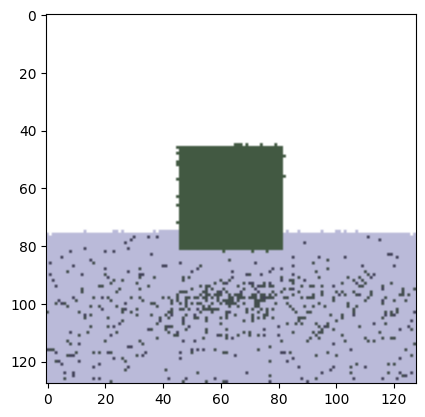

In [ ]:
correctAndShowImage(img)


## Optimierungen

bis jetzt ist der Raytracer noch sehr sehr langsam.
Eine Möglichkeit den Raytracer zu optimieren ist die Vektorisierung von Numpy zu nutzen.
Damit können gleiche Teile des Python Codes parallel ausgeführt werden.
Aktuell arbeitet der Raytracer alle Rays nacheinander ab.
Es werden zuerst alle Bounces des ersten Ray berechnet, dann alle Bounces des zweiten Ray berechnet, und so weiter.
Dabei greift die Optimierung von Numpy nicht.
Um die automatische Optimierung von Numpy zu ermöglichen muss die rendering funktion umgeschrieben werden.
Es muss zuerst der erste Bounce für alle Rays berechnet werden, dann der nächste Bounce für alle Rays berechnet und so weiter.

Da ein Ray nicht weiter an Objekten abprallen kann, wenn er entweder in einer Lichtquelle angelangt ist
oder kein Objekt getroffen hat, muss ein Filter eingeführt werden, der solche Rays für den nächsten Bounce herausfiltert.
In Python implementiert sieht das etwa so aus.


In [ ]:
# Get a point on the ray with distance t to the origin of the ray
def rayAt(ray, t):
    return ray[0] + t * ray[1]

# generates all the Rays at once


def generateRays(camera, itterations):
    width = camera.imageSize.width
    height = camera.imageSize.height
    rays = np.zeros((height*width*itterations, 3, 3))
    for x in range(width):
        for y in range(height):
            for j in range(itterations):
                rays[x+y*width+j*width*height] = camera._getRay(x, y)
    return rays

# create an image from all the rays


def createImage(rays, width, height, itterations):
    img = np.zeros((width, height, 3))
    for x in range(width):
        for y in range(height):
            for j in range(itterations):
                img[x, y] += rays[x+y*width+j*width*height, 2]
    return img

# lets all Rays hit a specific Object


def hitObject(obj, rays):
    t, normals, hitPoints, material = obj.hit(rays)
    hits = np.array([(tn, n, m) for tn, n, m in zip(t, normals, material)],
                    dtype="float64, object, object")
    return hits

# return the minimal but still >0 value of a[0] or b[0]


def filterMin(a, b):
    if (a[0] > 0):
        if (b[0] > 0):
            if (a[0] < b[0]):
                return a
            return b
        return a
    return b

# generate a new Ray with the Material in the Hit


def rayFromHit(ray, hit):
    return hit[2].outRay(ray, hit[1], rayAt(ray, hit[0]))

# Bounce all Rays once


def bounce(rays, objects):
    # Intialize the Ray filter and the hits
    rayFilter = np.full(rays.shape[0], True)
    hits = np.full((rays.shape[0]), np.array(
        [(-1, None, None)], dtype="float64, object, object"))

    # hit all Objects
    for obj in objects:
        # Hit the current Object with all the Rays
        newHits = hitObject(obj, rays)

        # find the first Hit of all the Rays and update the Hits accordingly
        hits = np.array([filterMin(h, nh)
                         for h, nh in zip(hits, newHits)])

    # update the Ray filter with all rays that didn't hit anything
    rayFilter &= np.array([h[0] > 0 for h in hits])

    # if everything is filtered out return
    if (not np.any(rayFilter)):
        return (rays, rayFilter)

    # let all Rays interact with the Material of the hit
    rays[rayFilter] = np.array([rayFromHit(ray, hit)
                                for hit, ray in zip(hits[rayFilter], rays[rayFilter])])

    # Filter all the Rays that hit Emissive Objects out
    rayFilter[rayFilter] &= np.invert(
        np.all(rays[rayFilter][:, 1] == 0, axis=1))

    # Return all the rays and the RayFilter update
    return (rays, rayFilter)


def render(camera: Camera, objects: list[Object], bounces: int = 5, itterations: int = 1):
    width = camera.imageSize.width
    height = camera.imageSize.height

    # generate all the Rays
    rays = generateRays(camera, itterations)
    rayFilter = np.full(rays.shape[0], True)

    # bounce the Rays
    for i in range(bounces):
        print('bounce {}/{}       '.format(i+1, bounces), end='\r')
        # bounce all the Rays that are allowed to bounce once and update the filter
        rays[rayFilter], rayFilter[rayFilter] = bounce(
            rays[rayFilter], objects)
        # if everything is filtered out break the loop
        if (not np.any(rayFilter)):
            break

    # Convert the Color Values of the Rays to an Image
    img = createImage(rays, width, height, itterations)

    return img


Diese Implementierung ist allerdings noch nicht funktionsfähig und auch noch nicht wirklich optimiert.
Um die Vektorisierung von Numpy auszunutzen, Sollte an jeder stelle an der es möglich ist Numpy verwendet werden.
So wird ein Ray nun nicht mehr durch einen Tuple dargestellt sondern durch ein Numpy array.
Daher muss die Camera Funktion und die Materialien entsprechend angepasst werden.


In [ ]:
class Camera:
    def __init__(
        self, imageSize: ImageSize,
        # set sane defaults
        position: Vec = np.array([0, 0, 0]), direction: Vec = np.array([1, 0, 0]), up: Vec = np.array([0, 0, 1])
    ) -> None:
        assert 0 < imageSize.width and 0 < imageSize.height, f"image cant have negative Dimestions, was {imageSize}"
        # setup
        self.imageSize = imageSize
        # sensor plane is 1 unit diagonal calculate the size of a pixel within 1 unit diagonal sensor
        self.unitPerPixel = np.sqrt(
            self.imageSize.width ** 2 + self.imageSize.height ** 2)

        # set sensor and aperture position (sensor is in front of aperture with direction)
        self.sensorPosition = position+direction
        self.aperturePosition = position

        # set the up and left values of the sensor (where the top and the left side of the sensor is)
        self.up = normalizeVector(up)
        self.left = normalizeVector(np.cross(direction, self.up))

    def _getRay(self, pixelX: int, pixelY: int) -> Ray:
        assert 0 <= pixelX < self.imageSize.width, f"pixelX has to be in Image, was {pixelX}"
        assert 0 <= pixelY < self.imageSize.height, f"pixelY has to be in Image, was {pixelY}"

        # set pixel position from 2d to 3d and add random offset within pixel (for anti aliasing)
        x = -self.imageSize.width/2 + pixelX + np.random.rand()
        y = -self.imageSize.height/2 + pixelY + np.random.rand()

        # set the Pixel Position in 3D Space using the left and the up vectors
        pixelPos = self.sensorPosition - self.left * \
            (x/self.unitPerPixel) - self.up*(y/self.unitPerPixel)

        # calculate ray direction
        rayDirection = normalizeVector(pixelPos - self.aperturePosition)

        # return Ray
        return np.array([self.aperturePosition, rayDirection, np.array([1, 1, 1])])


class Material(ABC):
    @abstractmethod
    def outRay(self, inRay, normal: Vec, hitPoint: Vec):
        pass


class Lambert(Material):
    def __init__(self, diffuseColor,  specularColor=np.array([0, 0, 0]), diffuseVsSpecular=1, specularIndex=0) -> None:
        self.diffuseColor = diffuseColor
        self.specularColor = specularColor
        self.diffuseVsSpecular = diffuseVsSpecular
        self.specularIndex = specularIndex
        super().__init__()

    def outRay(self, inRay, normal: Vec, hitPoint: Vec):
        rayDirection = inRay[1]
        rayColor = inRay[2]

        # Auswahl diffus oder specular (zahl zwischen [0,1])
        select = np.random.rand(1)

        # Ray werte inizialisieren
        location = hitPoint
        color = np.zeros((3))
        direction = np.zeros((3))

        # Werte die sonnst genutzt werden inizialisieren/normieren
        randomOnSphere = randomOnUnitSphere()
        normal = normalizeVector(normal)

        # Reflektionsanteil berechnen
        if (select > self.diffuseVsSpecular):
            reflected = reflect(normalizeVector(rayDirection), normal)
            direction = reflected + self.specularIndex * randomOnSphere
            color = rayColor * self.specularColor
            if (np.dot(direction, normal) < 0):
                direction = reflected

        # diffusen anteil berechnen
        if (select <= self.diffuseVsSpecular):
            point = randomOnSphere + normal + hitPoint
            direction = point - hitPoint
            color = rayColor * self.diffuseColor

        # Werte normieren
        direction = normalizeVector(direction)

        # neuen Ray zurückgeben
        return np.array([location, direction, color])


class Emissive(Material):
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

    def outRay(self, inRay, normal: Vec, hitPoint: Vec):
        rayColor = inRay[2]

        direction = np.array([0, 0, 0])
        location = np.array([0, 0, 0])
        color = rayColor * self.color
        return np.array([location, direction, color])


Nun kann man einfach Teile des Codes analysieren in dem die Laufzeit eines Codeabschnittes gemessen wurd
und dadurch Stellen erkennen die deutlichen Optimierungsbedarf haben.
Dazu gehören insbesondere die `object.hit` Funktionen der Objekte, da diese sehr oft ausgefürt werden.
Hier ist eine Optimierung möglich indem die ganze Funktion alle Rays gleichzeitig auf einen Treffer prüft,
statt jeden Ray einzeln nacheinander zu testen.
Dafür muss die Funktion für beide Objekttypen allerdings deutlich angepasst werden.


In [ ]:
# dot product for axis 1
def elemwiseDot(a, b):
    return np.sum(a*b, axis=1)

# normalize multiple vectors


def normalizeVector(vec: Vec, useAxis=None):
    return vec/np.linalg.norm(vec, axis=useAxis, keepdims=True)

# rayAt but for more Rays


def raysAt(rays, t):
    return rays[:, 0] + t[:, None] * rays[:, 1]


class Object(ABC):
    @abstractmethod
    def hit(self, rays):
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def hit(self, rays):
        locations = rays[:, 0]
        directions = rays[:, 1]

        # calculate b, c and delta
        a = 1
        b = 2 * elemwiseDot(directions, (locations - self.center))
        c = np.linalg.norm(locations - self.center,
                           axis=1) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        filter = np.full(c.shape, False)
        filter[delta > 0] = True
        delta = delta[filter]
        b = b[filter]
        c = c[filter]

        # calculate t1 and t2
        t1 = (-b + np.sqrt(delta))/(2*a)
        t2 = (-b - np.sqrt(delta))/(2*a)

        # take the correct t
        tn = np.minimum(t1, t2)
        tn = np.where(tn > 0.0, tn, np.maximum(t1, t2))

        # init output variables
        t = np.full(rays.shape[0], -1.0)
        hitPoints = np.zeros((rays.shape[0], 3))
        normals = np.zeros((rays.shape[0], 3))
        material = np.full((rays.shape[0]), np.array(
            [(self.material)], dtype="object"))

        # set output variables
        hitPoints[filter] = raysAt(rays[filter], tn)
        normals[filter] = normalizeVector(hitPoints[filter] - self.center, 1)
        t[filter] = tn
        return (t, normals, hitPoints, material)


class Triangle(Object):
    def __init__(self, abc, material: Material) -> None:
        self.a = abc[0]
        self.b = abc[1]
        self.c = abc[2]
        self.ab = self.b - self.a
        self.bc = self.c - self.b
        self.ca = self.a - self.c
        ac = self.c - self.a
        self.normal = normalizeVector(np.cross(self.ab, ac))
        self.material = material
        super().__init__()

    def hit(self, rays):
        # initialize values
        locations = rays[:, 0]
        directions = rays[:, 1]
        filter = np.full(rays.shape[0], True)
        t = np.full(rays.shape[0], -1.0)
        hitPoints = np.zeros((rays.shape[0], 3))
        normals = np.full((rays.shape[0], 3), self.normal)
        material = np.full((rays.shape[0]), np.array(
            [(self.material)], dtype="object"))

        # calculate dn
        dn = elemwiseDot(directions, self.normal)

        # Filter out all values where there is no Intersection with the plane
        filter[dn == 0] = False

        # calculate all Values for t
        t[filter] = elemwiseDot(self.a - locations[filter], self.normal)/dn
        # calculate the hit point
        hitPoints[filter] = raysAt(rays[filter], t)

        # check if the hitpoint is in the triangle
        abn = elemwiseDot(
            np.cross(self.ab, hitPoints[filter] - self.a), self.normal)
        filter[filter] &= (abn > 0)
        bcn = elemwiseDot(
            np.cross(self.bc, hitPoints[filter] - self.b), self.normal)
        filter[filter] &= (bcn > 0)
        can = elemwiseDot(
            np.cross(self.ca, hitPoints[filter] - self.a), self.normal)
        filter[filter] &= (can > 0)

        # filter out all invalid entrys
        t[np.invert(filter)] = -1

        return (t, normals, hitPoints, material)


Damit können nun die vorherigen Szenen wieder einfach umgesetzt werden.


In [ ]:
camera = Camera(ImageSize(128, 256))
objects = [Circle(np.array([75, 0, 0]), 10, Lambert([0.5, 0.7, 0.5], 1)),
           Circle(np.array([75, 0, -20]), 10,
                  Lambert([0, 0, 0], [0.5, 0.7, 0.5], 0, 0)),
           Circle(np.array([75, 0, 20]), 10, Lambert(
               [0, 0, 0], [0.5, 0.7, 0.5], 0, 0.5)),
           Circle(np.array([0, 5000, 0]),
                  4990, Lambert([0.5, 0.5, 0.7])),
           Circle(np.array([0, 0, 0]), 5000, Emissive([5, 5, 5]))]

img = render(camera, objects, 5, 5)


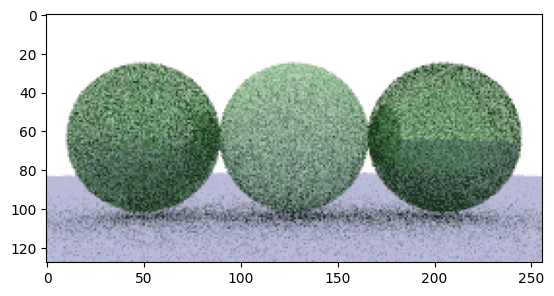

In [ ]:
correctAndShowImage(img)


## Cornell Box

Die Cornell Box ist ein in der Computergrafik häufig genutztes Bild verschiedene rendering Verfahren zu testen und zu validieren. Auf der Seite https://www.graphics.cornell.edu/online/box/data.html sind alle Spezifikationen der Cornell Box genau angegeben. Um den hier gebauten Raytracer zu validieren wird nun auch diese Box verwendet.  
Da die Werte dort allerdings nur als Flächen angegeben sind und nicht direkt als dreiecke, muss eine Hilfsfunktionen her, die eine Fläche in Dreiecke umwandelt.
Um für ein Quadrat nun nicht alle Flächen angeben zu müssen wird außerdem eine Hilfsfunktion für Quadrate erstellt.


In [ ]:
def Plane(origin, directions, material):
    p1 = origin
    p2 = origin + directions[0]
    p3 = origin + directions[1]
    p4 = p2 + directions[1]
    #point3 = points[2] + (points[1] - points[0])
    return [
        Triangle(np.array([
            np.array(p2),
            np.array(p1),
            np.array(p3),
        ]), material),
        Triangle(np.array([
            np.array(p2),
            np.array(p3),
            np.array(p4),
        ]), material),
    ]


def Block(origin, directions, material):
    # bottom
    p1 = origin
    p2 = p1 + directions[0]
    p3 = p1 + directions[1]
    p4 = p1 + directions[2]

    return [
        *Plane(p1, np.array([
            directions[0], directions[1]
        ]), material),
        *Plane(p1, np.array([
            directions[1], directions[2]
        ]), material),
        *Plane(p1, np.array([
            directions[0], directions[2]
        ]), material),
        *Plane(p2, np.array([
            directions[1], directions[2]
        ]), material),
        *Plane(p3, np.array([
            directions[0], directions[2]
        ]), material),
        *Plane(p4, np.array([
            directions[0], directions[1]
        ]), material)
    ]


Nun kann die Szene für die Cornell-Box eingerichtet und gerendert werden.


In [ ]:
white = Lambert([0.8, 0.8, 0.8])
light = Emissive([500, 500, 500])
blue = Lambert([0.5, 0.5, 1])
red = Lambert([1, 0.5, 0.5])
yellow = Lambert([1, 1, 0.5])

floor = Plane(np.array([0.0, 0.0, 0.0]),
              np.array([
                  [552.8, 0.0, 0.0],
                  [0.0, 0.0, 559.2]
              ]), white)

light = Plane(np.array([343.0, 548.7, 332.0]),
              np.array([
                  [0.0, 0.0, -105.0],
                  [-130.0, 0.0, 0.0]
              ]), light)

ceiling = Plane(np.array([556.0, 548.8, 559.2]),
                np.array([
                    [0.0, 0.0, -559.2],
                    [-556.0, 0.0, 0.0]
                ]), white)

backWall = Plane(np.array([0.0, 0.0, 559.2]),
                 np.array([
                     [549.6,   0.0, 0.0],
                     [0.0, 548.8, 0.0]
                 ]), white)

rightWall = Plane(np.array([0.0, 0.0, 0.0]),
                  np.array([
                      [0.0, 0.0, 559.2],
                      [0.0, 548.8, 0.0]
                  ]), blue)

leftWall = Plane(np.array([549.6,   0.0, 559.2]),
                 np.array([
                     [3.2,   0.0,   -559.2],
                     [6.4, 548.8, 0.0]
                 ]), red)

shortBlock = Block(np.array([500.0, 165.0, 200.0]),
                   np.array([
                       [0.0, -165.0, 0.0],
                       [-160.0, 0.0, -49.0],
                       [-50.0, 0.0, 158.0]
                   ]), yellow)

tallBlock = Block(np.array([290.0, 330.0, 406.0]),
                  np.array([
                      [-49.0, 0.0, -159.0],
                      [-158.0, 0.0, 50.0],
                      [0.0, -330.0, 0.0]
                  ]), blue)

objects: list[Object] = [*floor, *light, *ceiling, *
                         backWall, *rightWall, *leftWall, *shortBlock, *tallBlock]

camera = Camera(ImageSize(128, 128), np.array(
    [278, 273, -800]), np.array([0, 0, 1]), np.array([0, 1, 0]))

img = render(camera, objects, 5, 2)


Matplotlib hat die seltsame Eigenschaft bilder um 90° gedreht anzuzeigen, das liegt daran, dass die erste Dimension als y interpretiert wird und nicht als x, bissher konnte das umgangen werden, indem einfach die Szene um 90° gedreht wurde, das wollen wir hier nicht machen.


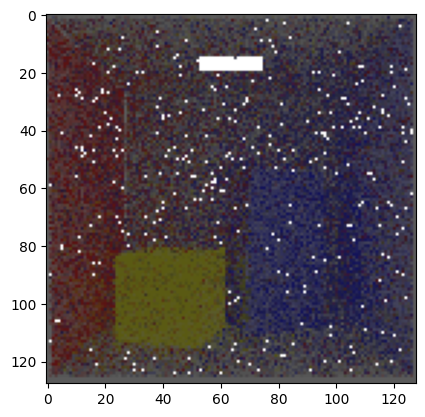

In [ ]:
from scipy import ndimage
from PIL import Image
import time

i = ndimage.rotate(img, -90)
m = np.max(img)/50
i = np.power((i/m), 0.45)
i = np.clip(i, 0, 1)
fig = plt.imshow(i)
plt.imsave('{}-cornell_box.png'.format(int(time.time())), i)


Nach einer sehr langen Render-Zeit erhält man dann folgendes Bild:  
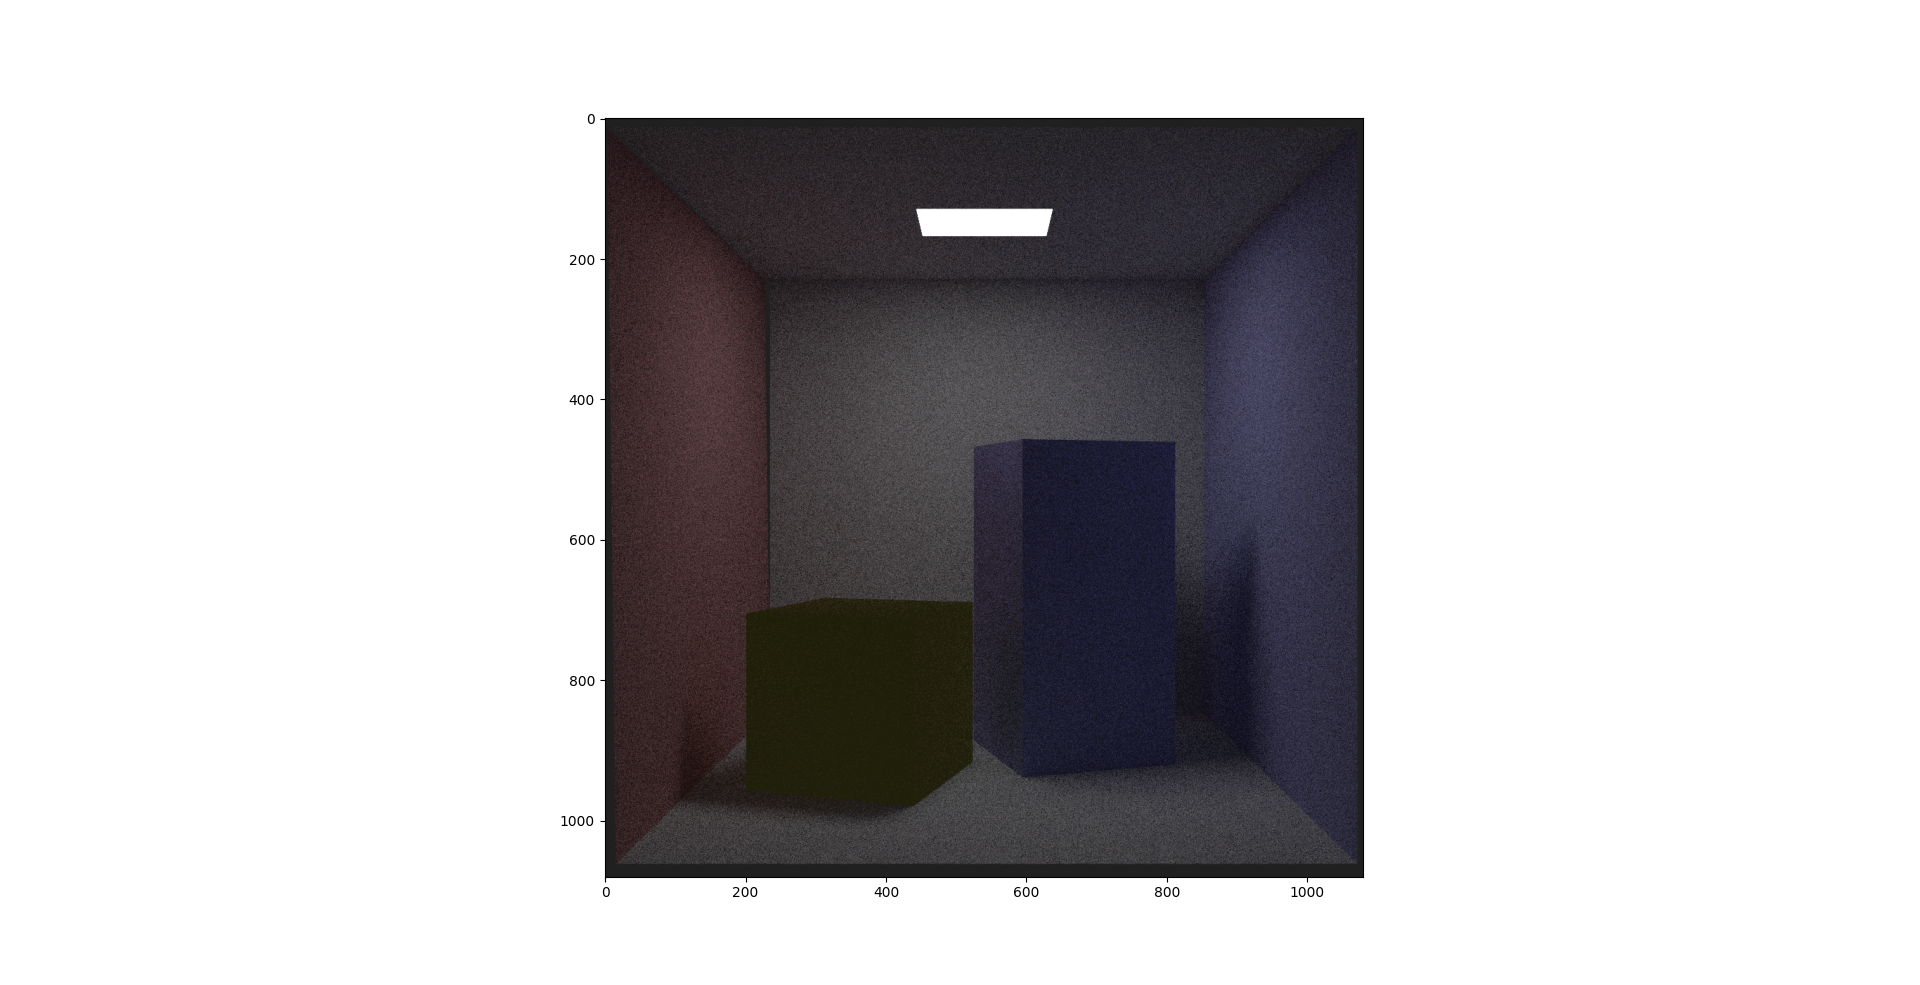